[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/mhuertascompany/euclid-school-2025/blob/main/Y2/notebooks/MNIST_ScoreDiffusion.ipynb)

# Score-based Diffusion on MNIST 
## Rodolphe Cledassou School 2025

> Marc Huertas-Company & Hubert Bretonnière

We train a noise-conditional score model on MNIST via **denoising score matching** in the DDPM/VP formulation.

## 1) Setup

In [ ]:
# --- EUCLID SCHOOL: LIGHT BOOTSTRAP (no data) -------------------------------
# Detect Colab, (optionally) install minimal deps, (optionally) clone the repo,
# and print device info. It does NOT download any dataset.
# ----------------------------------------------------------------------------
import os, sys, subprocess
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# --- Colab detection
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    pass

# --- Settings (edit if needed)
INSTALL_DEPS = True                # set False if you want to skip pip installs on Colab
PIP_PKGS = [
    # Keep small. Colab already has torch + CUDA.
    "datasets==4.*", "transformers==4.*", "timm==1.*", "albumentations==2.*",
    "lightning==2.*", "pytorch-lightning==2.*", "einops==0.*",
    "pyarrow", "seaborn", "umap-learn", "nflows",
    "tensorboard", "tqdm", "safetensors", "opencv-python"
]

# If your notebook relies on repo-relative paths, you can enable this:
CLONE_REPO = False                 # set True only if needed
REPO_URL   = "https://github.com/mhuertascompany/euclid-school-2025.git"
REPO_DIR   = "/content/euclid-school-2025"
SUBDIR     = None                  # e.g., "Y1/notebooks" or "Y2/xyz"

def pip_install(pkgs):
    if not pkgs: return
    cmd = [sys.executable, "-m", "pip", "install", "-q", "--upgrade"] + list(pkgs)
    subprocess.run(cmd, check=True)

if IN_COLAB:
    print("Running on Google Colab ✓")
    if INSTALL_DEPS:
        print("Installing minimal pip deps…")
        pip_install(PIP_PKGS)

    if CLONE_REPO:
        if not os.path.isdir(REPO_DIR):
            print(f"Cloning {REPO_URL} …")
            subprocess.run(["git", "clone", "-q", REPO_URL, REPO_DIR], check=True)
        if SUBDIR:
            os.chdir(os.path.join(REPO_DIR, SUBDIR))
            print("Working directory:", os.getcwd())

    # Device info
    try:
        subprocess.run(["nvidia-smi"], check=False)
    except Exception:
        pass
else:
    print("Not running on Colab (no action).")
# ----------------------------------------------------------------------------
import torch
print("\nPyTorch:", torch.__version__)
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

In [ ]:
import os, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt

torch.manual_seed(0); np.random.seed(0)
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

device: cpu


## 2) Hyperparameters

In [2]:
img_size   = 28
in_ch      = 1
T          = 300
beta_start = 1e-4
beta_end   = 0.02
batch_size = 128
epochs     = 10
lr         = 2e-4
sample_every = 1
out_dir = "mnist_diffusion_outputs"
os.makedirs(out_dir, exist_ok=True)

## 3) Data loading (MNIST)

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

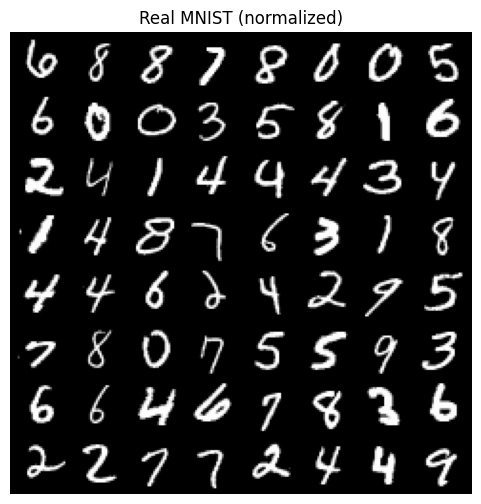

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

x_real = next(iter(train_loader))[0][:64]
grid = vutils.make_grid(x_real, nrow=8, normalize=True, value_range=(-1,1))
plt.figure(figsize=(6,6)); plt.axis("off"); plt.title("Real MNIST (normalized)")
plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0))); plt.show()

## 4) Diffusion utilities (betas, alphas)

In [4]:
betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32, device=device)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

def extract(a, t, x_shape):
    out = a.gather(-1, t).float()
    return out.view(-1, *((1,)*(len(x_shape)-1)))

@torch.no_grad()
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_ab = extract(torch.sqrt(alphas_bar), t, x0.shape)
    sqrt_mab = extract(torch.sqrt(1.0 - alphas_bar), t, x0.shape)
    return sqrt_ab * x0 + sqrt_mab * noise, noise

## 5) Time embedding

In [7]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim, max_period=10000):
        super().__init__()
        self.dim = dim
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim*4), nn.SiLU(),
            nn.Linear(dim*4, dim*4), nn.SiLU(),
            nn.Linear(dim*4, dim),
        )
        self.max_period = max_period
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-math.log(self.max_period) * torch.arange(0, half, device=t.device).float() / half)
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0) * 2*math.pi / T
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1))
        return self.mlp(emb)

## 6) Model — small U-Net-ish predictor

In [8]:
def conv_block(in_c, out_c, time_dim):
    return nn.ModuleDict({
        "conv": nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.GroupNorm(8, out_c), nn.SiLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.GroupNorm(8, out_c), nn.SiLU(),
        ),
        "time": nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_c))
    })

class UNetMini(nn.Module):
    def __init__(self, in_ch=1, base=64, time_dim=128):
        super().__init__()
        self.time_mlp = TimeEmbedding(time_dim)
        self.in_conv = nn.Conv2d(in_ch, base, 3, padding=1)
        self.down1 = conv_block(base, base*2, time_dim); self.pool = nn.AvgPool2d(2)
        self.down2 = conv_block(base*2, base*4, time_dim)
        self.mid   = conv_block(base*4, base*4, time_dim)
        self.up1_t = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.up1   = conv_block(base*4, base*2, time_dim)
        self.up2_t = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.up2   = conv_block(base*2, base, time_dim)
        self.out_conv = nn.Conv2d(base, in_ch, 3, padding=1)
    def _apply_block(self, block, h, t_emb):
        temb = block["time"](t_emb)[:, :, None, None]
        h = block["conv"](h) + temb
        return h
    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        h0 = self.in_conv(x)
        h1 = self._apply_block(self.down1, self.pool(h0), t_emb)
        h2 = self._apply_block(self.down2, self.pool(h1), t_emb)
        hm = self._apply_block(self.mid, h2, t_emb)
        u1 = self.up1_t(hm); u1 = torch.cat([u1, h1], dim=1); u1 = self._apply_block(self.up1, u1, t_emb)
        u2 = self.up2_t(u1); u2 = torch.cat([u2, h0], dim=1); u2 = self._apply_block(self.up2, u2, t_emb)
        return self.out_conv(u2)

model = UNetMini(in_ch=1, base=64, time_dim=128).to(device)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Params: 3510465


## 7) Loss & optimizer (denoising MSE)

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

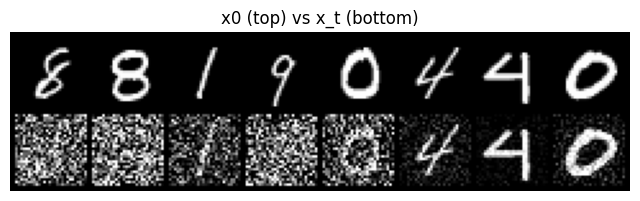

In [10]:
opt = optim.AdamW(model.parameters(), lr=lr)

def diffusion_loss(x0):
    B = x0.size(0)
    t = torch.randint(0, T, (B,), device=x0.device).long()
    x_t, noise = q_sample(x0, t)
    eps_pred = model(x_t, t)
    return F.mse_loss(eps_pred, noise)

with torch.no_grad():
    xb = next(iter(train_loader))[0][:8].to(device)
    tb = torch.randint(0, T, (xb.size(0),), device=device)
    xt, eps = q_sample(xb, tb)
    grid = vutils.make_grid(torch.cat([xb, xt], dim=0), nrow=8, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(8,4)); plt.axis("off"); plt.title("x0 (top) vs x_t (bottom)")
    plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0))); plt.show()

## 8) Sampling (ancestral DDPM)

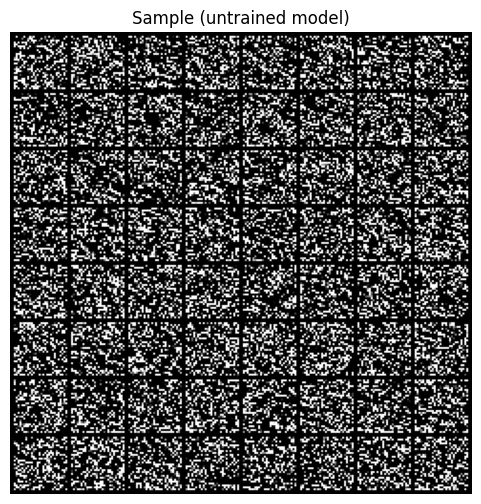

In [11]:
@torch.no_grad()
def p_sample_loop(n=64):
    x = torch.randn(n, in_ch, img_size, img_size, device=device)
    for t_step in reversed(range(T)):
        t = torch.full((n,), t_step, device=device, dtype=torch.long)
        eps_theta = model(x, t)
        beta_t   = extract(betas, t, x.shape)
        alpha_t  = extract(alphas, t, x.shape)
        ab_t     = extract(alphas_bar, t, x.shape)
        mean = (1/torch.sqrt(alpha_t)) * (x - (beta_t/torch.sqrt(1 - ab_t)) * eps_theta)
        if t_step > 0:
            beta_tilde = beta_t * (1 - extract(alphas_bar, t-1, x.shape)) / (1 - ab_t)
            x = mean + torch.sqrt(beta_tilde) * torch.randn_like(x)
        else:
            x = mean
    return x.clamp(-1,1)

samp = p_sample_loop(64).cpu()
grid = vutils.make_grid(samp, nrow=8, normalize=True, value_range=(-1,1))
plt.figure(figsize=(6,6)); plt.axis("off"); plt.title("Sample (untrained model)")
plt.imshow(np.transpose(grid.numpy(), (1,2,0))); plt.show()

## 9) Training loop

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[01/10] loss=0.1128 (586.1s)


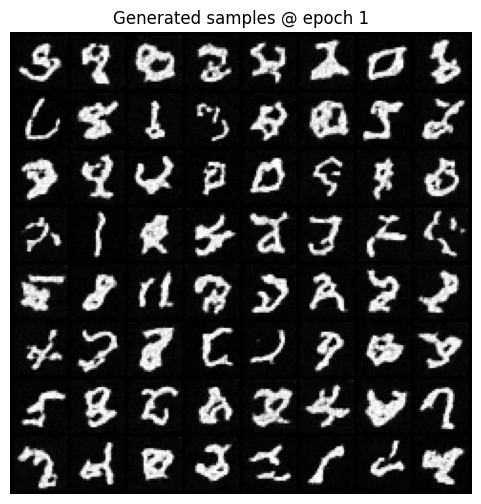

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[02/10] loss=0.0597 (597.2s)


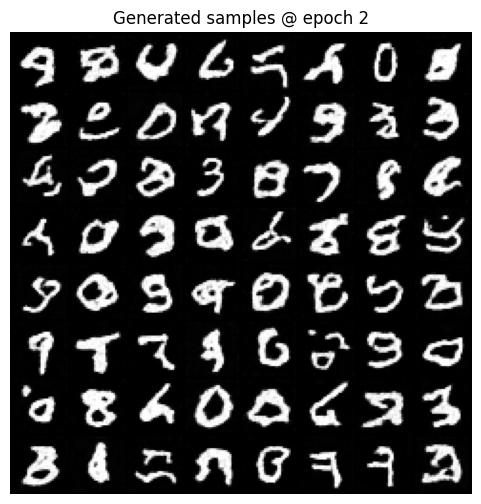

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[03/10] loss=0.0534 (605.7s)


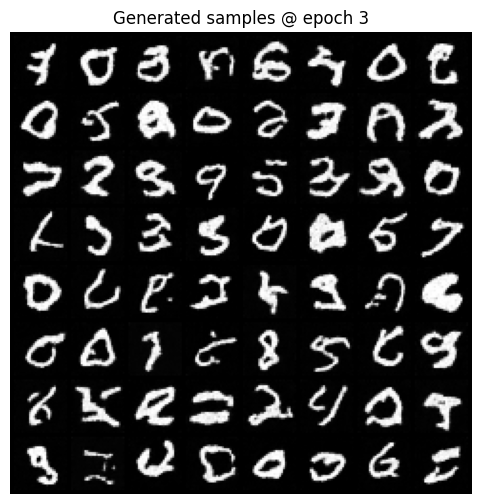

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[04/10] loss=0.0503 (594.8s)


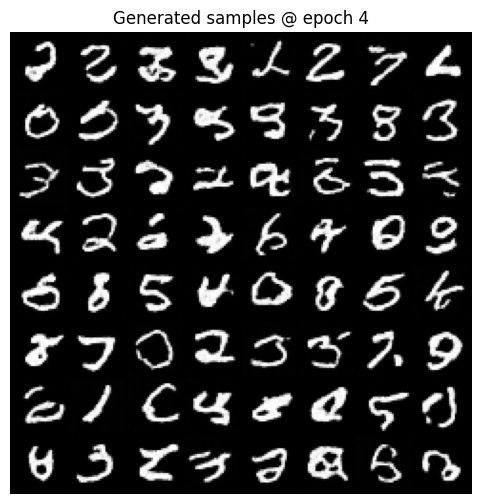

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[05/10] loss=0.0491 (1331.9s)


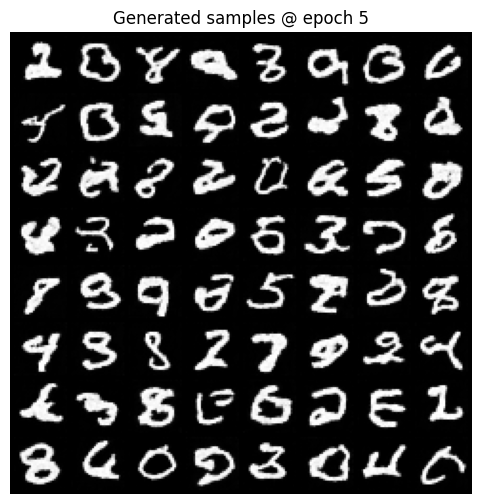

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

[06/10] loss=0.0475 (597.3s)


KeyboardInterrupt: 

In [12]:
log = []
for ep in range(1, epochs+1):
    t0 = time.time()
    for x,_ in train_loader:
        x = x.to(device, non_blocking=True)
        loss = diffusion_loss(x)
        opt.zero_grad(); loss.backward(); opt.step()
        log.append(loss.item())
    print(f"[{ep:02d}/{epochs}] loss={np.mean(log[-len(train_loader):]):.4f} ({time.time()-t0:.1f}s)")
    if ep % sample_every == 0:
        with torch.no_grad():
            xg = p_sample_loop(64).cpu()
            grid = vutils.make_grid(xg, nrow=8, normalize=True, value_range=(-1,1))
        plt.figure(figsize=(6,6)); plt.axis("off")
        plt.title(f"Generated samples @ epoch {ep}")
        plt.imshow(np.transpose(grid.numpy(), (1,2,0))); plt.show()
        vutils.save_image(xg, os.path.join(out_dir, f"samples_epoch_{ep:03d}.png"),
                          nrow=8, normalize=True, value_range=(-1,1))

## 10) Loss curve

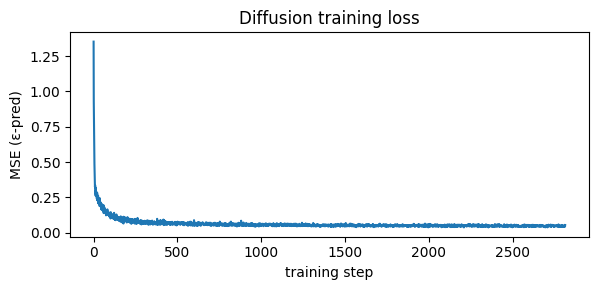

In [13]:
plt.figure(figsize=(6,3))
plt.plot(log)
plt.xlabel("training step"); plt.ylabel("MSE (ε-pred)")
plt.title("Diffusion training loss"); plt.tight_layout(); plt.show()

## 11) Notes
- Linear beta schedule; try cosine for better quality.
- Model predicts noise; predicting \(x_0\) or \(v\) are alternatives.
- For faster sampling, try DDIM (drop noise, subsample steps).